## Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin

from src.dataset.paired_audio_dataset import PairedAudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.style_transfer_vae import StyleTransferVAE

## Helper Functions

In [2]:
def show_spectrogram(audio):
    if len(audio.shape) == 1:
        audio = audio.unsqueeze(0)
        audio = audio.unsqueeze(0)

    spec = model.audio_to_spectrogram(signal=audio, return_phase=False)
    plt.imshow(spec.detach().squeeze(), aspect='auto')
    plt.show()

In [3]:
def get_stack_from_audio(x, y):
    if len(y.shape) == 1:
        y = y.unsqueeze(0).unsqueeze(0)
    x_s = model.audio_to_spectrogram(signal=x, return_phase=False)
    y_s = model.audio_to_spectrogram(signal=y, return_phase=False)
    X = torch.concat([x_s, y_s], dim=1)
    return X

In [44]:
def interpolate(model, x_1, x_2, n=10, title="", save_fig=False, save_filename=""):
    _,_,_, z_1 = model(x_1)
    _,_,_, z_2 = model(x_2)

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = model.decode(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    minmin = np.min(interpolate_list)
    maxmax = np.max(interpolate_list)

    fig, axes = plt.subplots(2, n, figsize=(12,5))

    for i in range(0,n):
        axes[0,i].imshow(interpolate_list[i,0,:,:], vmin=minmin, vmax=maxmax, aspect='auto')
        axes[1,i].imshow(interpolate_list[i,1,:,:], aspect='auto')

        axes[0,i].set_xticks([])
        axes[0,i].set_yticks([])

        axes[1,i].set_xticks([])
        axes[1,i].set_yticks([])

        if i == 0:
            axes[0,i].set_title("$\hat{X}_1$")
        if i == n-1:
            axes[0,i].set_title("$\hat{X}_2$")

    axes[0,0].set_ylabel("Input Audio")
    axes[1,0].set_ylabel("Target Audio")

    fig.suptitle(title)
    plt.tight_layout()

    if save_fig:
        plt.savefig(save_filename)
    else:
        plt.show()

In [45]:
def interpolate_with_originals(model, x_1, x_2, n=10, title="", save_fig=False, save_filename=""):
    _,_,_, z_1 = model(x_1)
    _,_,_, z_2 = model(x_2)

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = model.decode(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    minmin = min([np.min(interpolate_list), torch.min(x_1).item(), torch.min(x_2).item()])
    maxmax = max([np.max(interpolate_list), torch.max(x_1).item(), torch.max(x_2).item()])

    # Enough subplots for 2 originals + interpolation
    fig, axes = plt.subplots(2, n+2, figsize=(12,5))

    # Plot original 1
    axes[0,0].imshow(x_1.detach().numpy()[0,0,:,:], vmin=minmin, vmax=maxmax, aspect='auto')
    axes[1,0].imshow(x_1.detach().numpy()[0,1,:,:], vmin=minmin, vmax=maxmax, aspect='auto')

    axes[0,0].set_xticks([])
    axes[0,0].set_yticks([])
    axes[0,0].set_ylabel("Input Audio")

    axes[1,0].set_xticks([])
    axes[1,0].set_yticks([])
    axes[1,0].set_ylabel("Target Audio")

    axes[0,0].set_title("$X_1$")

    for i in range(1,n+1):
        axes[0,i].imshow(interpolate_list[i-1,0,:,:], vmin=minmin, vmax=maxmax, aspect='auto')
        axes[1,i].imshow(interpolate_list[i-1,1,:,:], vmin=minmin, vmax=maxmax, aspect='auto')

        axes[0,i].set_xticks([])
        axes[0,i].set_yticks([])

        axes[1,i].set_xticks([])
        axes[1,i].set_yticks([])

        if i == 1:
            axes[0,i].set_title("$\hat{X}_1$")
        if i == n:
            axes[0,i].set_title("$\hat{X}_2$")

    # Plot original 2
    axes[0,n+1].imshow(x_2.detach().numpy()[0,0,:,:], vmin=minmin, vmax=maxmax, aspect='auto')
    axes[1,n+1].imshow(x_2.detach().numpy()[0,1,:,:], vmin=minmin, vmax=maxmax, aspect='auto')

    axes[0,n+1].set_xticks([])
    axes[0,n+1].set_yticks([])

    axes[1,n+1].set_xticks([])
    axes[1,n+1].set_yticks([])

    axes[0,n+1].set_title("$X_2$")

    fig.suptitle(title)
    plt.tight_layout()

    if save_fig:
        plt.savefig(save_filename)
    else:
        plt.show()

## Global Variables

In [46]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "clean"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 10
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_style_vae/ync68xdq/checkpoints/epoch=193-step=121250.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]

## Load pretrained model

In [47]:
model = StyleTransferVAE.load_from_checkpoint(CHECKPOINT)
model.eval()
print()

## Load (clean) Dataset

In [48]:
dataset = PairedAudioDataset(
    dafx = NullDAFXWrapper(),
    audio_dir=AUDIO_DIR,
    subset="train",
    input_dirs=DATASETS,
    num_examples_per_epoch=NUM_EXAMPLES,
    augmentations={},
    length=131_072,
    effect_input=False,
    effect_output=True,
    dummy_setting=True
)

loader= torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=1,
    timeout=6000,
)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 20882.53it/s]


Loaded 88 files for train = 66.89 hours.


## Load DAFX

In [49]:
delay_dafx = DAFXWrapper(dafx=load_plugin(DAFX_FILE, plugin_name="mda Delay"), sample_rate=SAMPLE_RATE)
overdrive_dafx = DAFXWrapper(dafx=load_plugin(DAFX_FILE, plugin_name="mda Overdrive"), sample_rate=SAMPLE_RATE)

# Interpolation - Same Audio, Different DAFX

In [50]:
batch = next(iter(loader))
x_clean, y_clean = batch

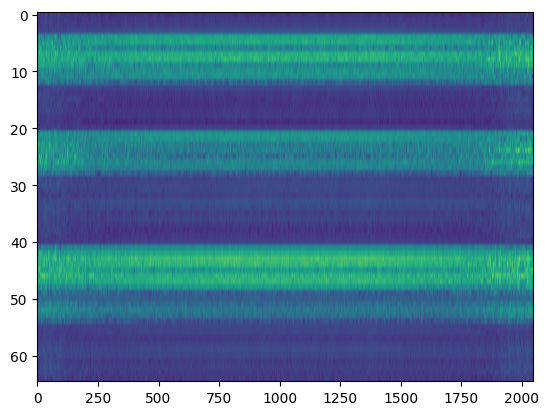

In [51]:
show_spectrogram(x_clean)

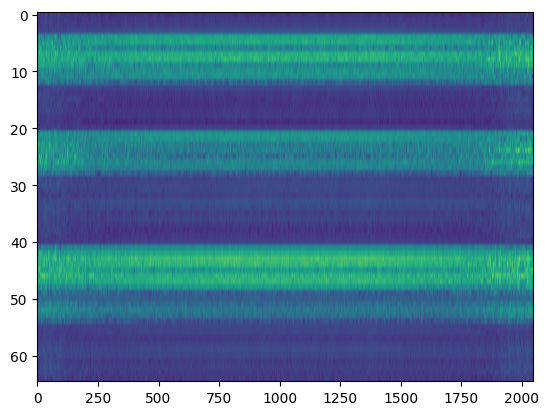

In [52]:
show_spectrogram(y_clean)

### Load Delay and apply to audio

In [53]:
y_delay = delay_dafx.process_audio_with_dummy_settings(y_clean)

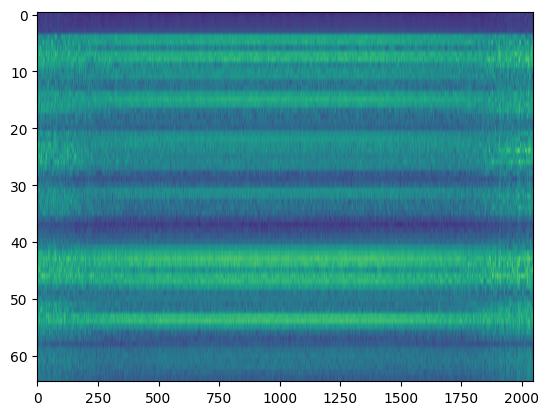

In [54]:
show_spectrogram(y_delay)

### Load Overdrive and apply to audio

In [55]:
y_overdrive = overdrive_dafx.process_audio_with_dummy_settings(y_clean)

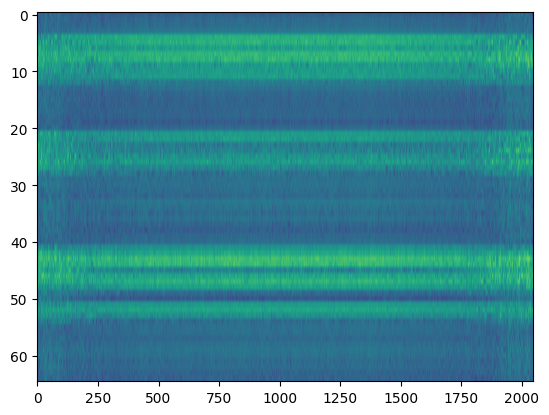

In [56]:
show_spectrogram(y_overdrive)

### Create stacks

In [57]:
X_delay = get_stack_from_audio(x_clean, y_delay)

In [58]:
X_overdrive = get_stack_from_audio(x_clean, y_overdrive)

## Interpolate

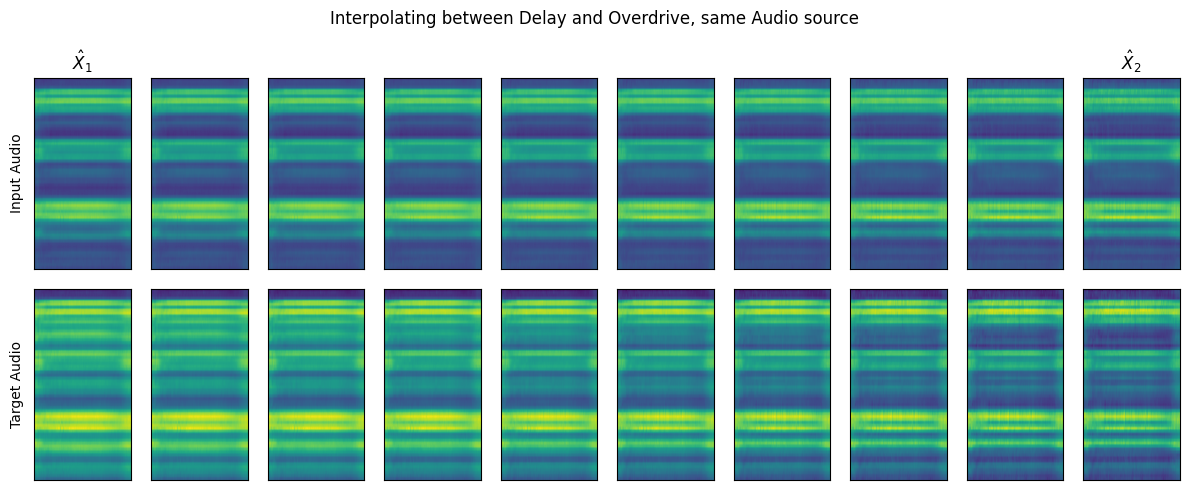

In [76]:
interpolate(model, X_delay, X_overdrive, title="Interpolating between Delay and Overdrive, same Audio source", save_fig=True, save_filename=f"./figures/{CHECKPOINT_ID}_same_audio_delay_overdrive_interpolation.svg")

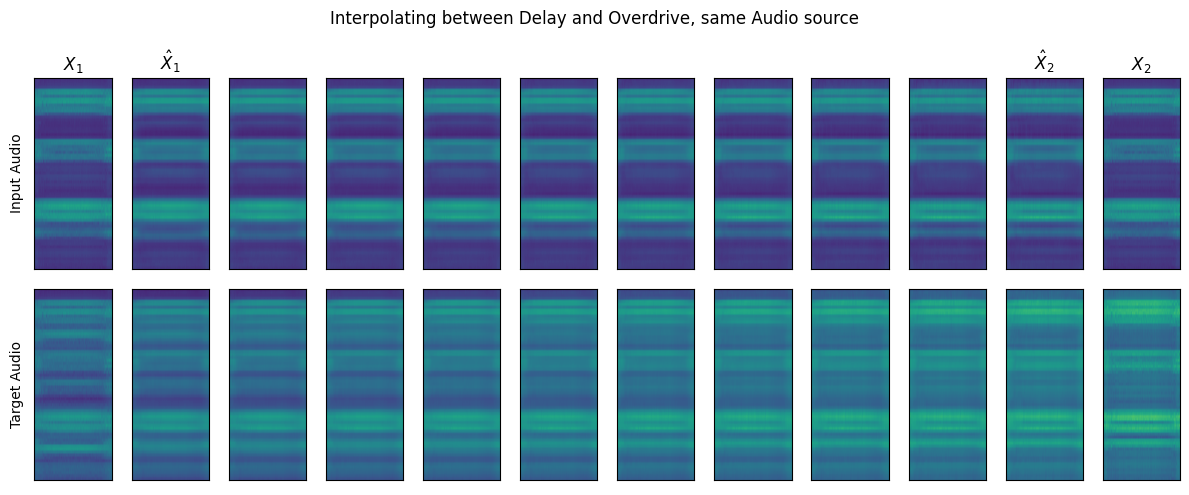

In [77]:
interpolate_with_originals(model, X_delay, X_overdrive, title="Interpolating between Delay and Overdrive, same Audio source", save_fig=True, save_filename=f"./figures/{CHECKPOINT_ID}_same_audio_delay_overdrive_interpolation_with_original.svg")

# Interpolate - Different Audio, Same Effect

In [61]:
batch = next(iter(loader))
x_a_clean, y_a_clean = batch

In [62]:
batch = next(iter(loader))
x_b_clean, y_b_clean = batch

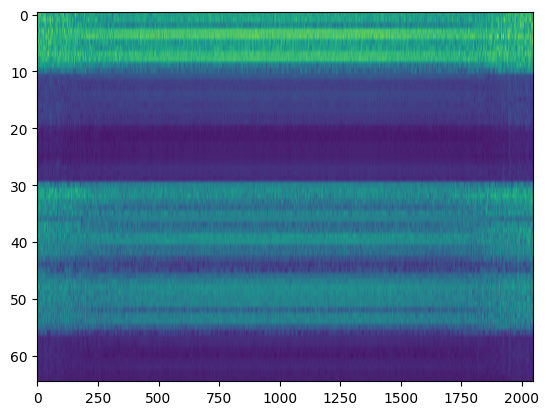

In [63]:
show_spectrogram(x_a_clean)

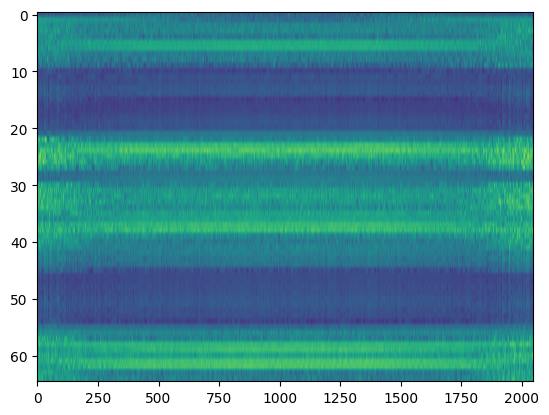

In [64]:
show_spectrogram(x_b_clean)

In [65]:
y_a_overdrive = overdrive_dafx.process_audio_with_dummy_settings(y_a_clean)

In [66]:
y_b_overdrive = overdrive_dafx.process_audio_with_dummy_settings(y_b_clean)

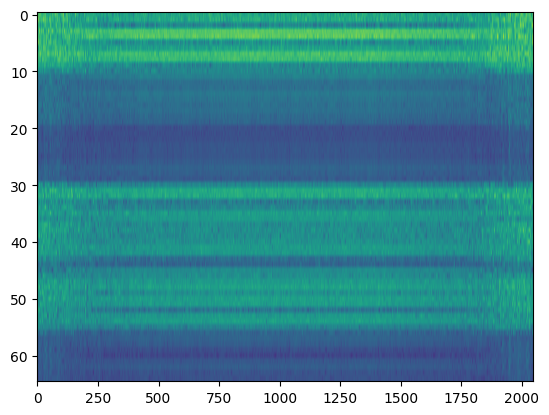

In [67]:
show_spectrogram(y_a_overdrive)

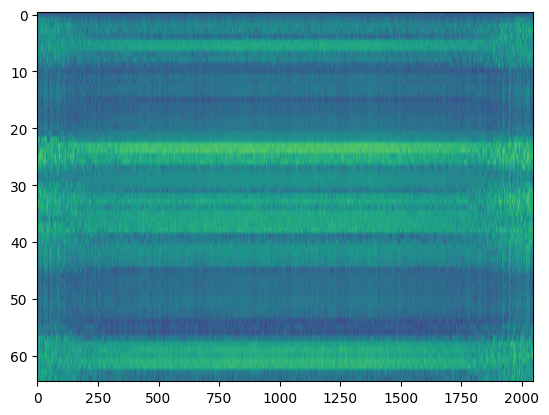

In [68]:
show_spectrogram(y_b_overdrive)

In [69]:
X_a = get_stack_from_audio(x_a_clean, y_a_overdrive)

In [70]:
X_b = get_stack_from_audio(x_b_clean, y_b_overdrive)

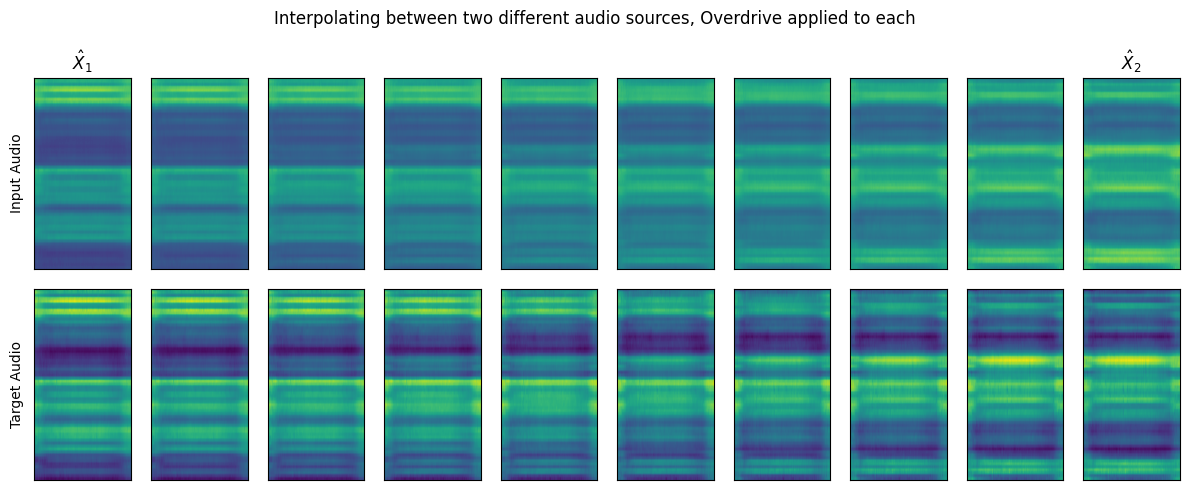

In [74]:
interpolate(model, X_a, X_b, n=10, title="Interpolating between two different audio sources, Overdrive applied to each", save_fig=True, save_filename=f"./figures/{CHECKPOINT_ID}_diff_audio_overdrive_interpolation.svg")

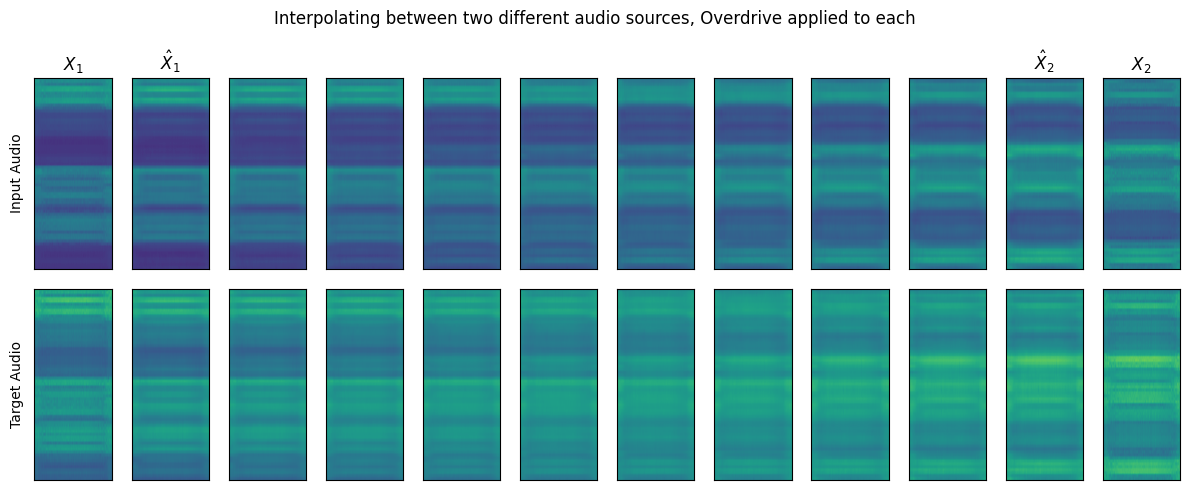

In [75]:
interpolate_with_originals(model, X_a, X_b, n=10, title="Interpolating between two different audio sources, Overdrive applied to each", save_fig=True, save_filename=f"./figures/{CHECKPOINT_ID}_diff_audio_overdrive_interpolation_with_original.svg")